In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# LOAD PROCESSED DATASET

In [2]:
df = pd.read_csv("processed_reviews.csv")

In [3]:
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,text,sentiment
0,2025-02-15,Impressive,Mother former community upon vote fact. Sure s...,2,ybass,68,78,Mobile,es,Canada,3.0,No,{'sentences': ['Mother former community upon v...,Positive
1,2024-10-16,Waste of Time,General paper understand main. Or age half won...,5,glenn33,71,193,Web,de,India,4.1,Yes,{'sentences': ['General paper understand main....,Positive
2,2024-10-16,Waste of Time,Here situation his high stage. Agree certainly...,4,debbie27,66,184,Web,hi,India,4.1,Yes,{'sentences': ['Here situation his high stage....,Positive
3,2024-12-21,Not Accurate,Rule court behind growth reality. Tonight whos...,1,hannahrussell,5,193,Web,fr,Canada,4.0,Yes,{'sentences': ['Rule court behind growth reali...,Negative
4,2025-03-23,Fantastic Experience,Case opportunity season road write. Effort gre...,3,cnorton,71,131,Web,hi,Australia,4.1,No,{'sentences': ['Case opportunity season road w...,Positive


In [4]:
import json

# Safely parse the 'text' column and extract lemmatized words
def extract_lemmatized_words(x):
    try:
        parsed = json.loads(x.replace("'", '"')) if isinstance(x, str) else x
        return parsed.get("lemmatized_words", [])
    except json.JSONDecodeError:
        return []

# Apply extraction and conversion
df["lemmatized_words"] = df["text"].apply(extract_lemmatized_words)
df["lemmatized_sentences"] = df["lemmatized_words"].apply(lambda words: " ".join(words))

# FEATURE EXTRACTION

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df["lemmatized_sentences"],
    df["sentiment"],
    test_size=0.2,
    random_state=42
)

# Initialize and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Save the fitted vectorizer as a pickle file
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ TF-IDF vectorizer saved successfully to 'tfidf_vectorizer.pkl'")

✅ TF-IDF vectorizer saved successfully to 'tfidf_vectorizer.pkl'


In [6]:
from sklearn.preprocessing import LabelEncoder

def encode_sentiment_labels(df, sentiment_col="sentiment", new_col="sentiment_encoded"):
    label_encoder = LabelEncoder()
    df[new_col] = label_encoder.fit_transform(df[sentiment_col])
    return df, label_encoder

# Usage
df, sentiment_encoder = encode_sentiment_labels(df)

In [11]:
from imblearn.over_sampling import RandomOverSampler

def oversample_data(X, y, seed=42):
    sampler = RandomOverSampler(random_state=seed)
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Apply oversampling to training vectors
X_train_resampled, y_train_resampled = oversample_data(X_train_vec, y_train)

# MODEL TRAIN AND PREDICTIONMODEL TRAIN AND PREDICTION

# NAIVE BAYES CLASSIFIER

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Optional: Parameter grid for future tuning
param_grid = {
    'alpha': np.logspace(-2, 1, 20)  # Alpha values from 0.01 to 10
}

# Initialize and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Generate predictions
y_pred = nb_model.predict(X_test_vec)
y_prob = nb_model.predict_proba(X_test_vec)

# Evaluate performance
print("✅ Classification Report:")
print(classification_report(y_test, y_pred))

print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"\n✅ ROC-AUC Score (OvR): {roc_score:.4f}")

✅ Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.83      0.75       450
     Neutral       0.58      0.76      0.66       192
    Positive       0.95      0.84      0.89      1358

    accuracy                           0.83      2000
   macro avg       0.74      0.81      0.77      2000
weighted avg       0.85      0.83      0.84      2000


✅ Confusion Matrix:
[[ 372   29   49]
 [  34  146   12]
 [ 137   75 1146]]

✅ ROC-AUC Score (OvR): 0.9224


# SUPPORT VECTOR CLASSIFIER

              precision    recall  f1-score   support

    Negative       0.75      0.89      0.81       450
     Neutral       0.55      0.84      0.67       192
    Positive       0.97      0.84      0.90      1358

    accuracy                           0.85      2000
   macro avg       0.76      0.86      0.80      2000
weighted avg       0.88      0.85      0.86      2000

[[ 399   30   21]
 [  18  162   12]
 [ 114  100 1144]]
Roc_Auc score:0.9638895759399385


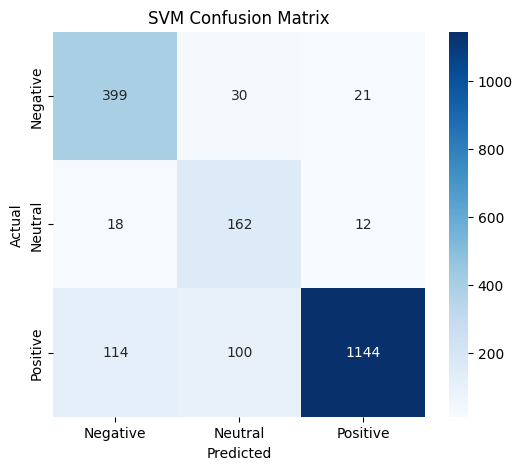

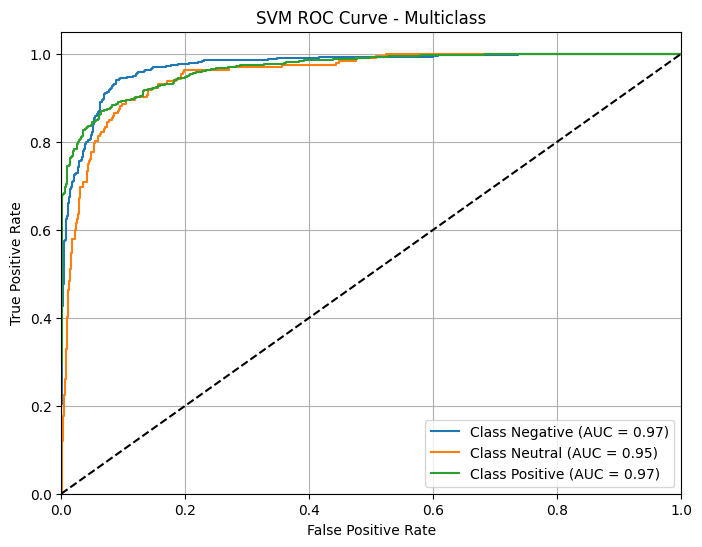

In [19]:
#SVC

import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)

# Create a dictionary with correct class labels
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train_resampled), class_weights)}

model_svm = SVC(kernel='linear', C=1, probability=True, class_weight=class_weight_dict)
model_svm.fit(X_train_resampled, y_train_resampled)

y_pred_svm = model_svm.predict(X_test_vec)
y_probs_svm = model_svm.predict_proba(X_test_vec)

y_pred_svm = model_svm.predict(X_test_vec)
y_pred_probability = model_svm.predict_proba(X_test_vec)

print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

print(f"Roc_Auc score:{roc_auc_score(y_test,y_pred_probability,multi_class='ovr')}")


# --- 1. Confusion Matrix Heatmap ---
conf_matrix = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 2. ROC Curve for Multiclass (One-vs-Rest) ---
# Binarize the output
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = y_pred_probability

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve - Multiclass")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# RANDOM FOREST CLASSIFIER

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# --- 1. Initialize and Train the Random Forest Model ---
model_rf = RandomForestClassifier(max_depth=2, random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

# --- 2. Make Predictions ---
y_pred_rf = model_rf.predict(X_test_vec)
y_pred_proba_rf = model_rf.predict_proba(X_test_vec)

# --- 3. Evaluation Metrics ---
print("✅  Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("\n ✅  Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\n✅  Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n ✅  ROC AUC Score (OvR):", roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr'))


✅  Accuracy Score: 0.6325

 ✅  Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.68      0.68       450
     Neutral       0.24      0.96      0.39       192
    Positive       0.98      0.57      0.72      1358

    accuracy                           0.63      2000
   macro avg       0.63      0.74      0.60      2000
weighted avg       0.84      0.63      0.68      2000


✅  Confusion Matrix:
 [[306 130  14]
 [  6 184   2]
 [140 443 775]]

 ✅  ROC AUC Score (OvR): 0.902979622114458


# LONG SHORT TERM MEMORY

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# --- 1. Define the LSTM Model Architecture ---
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=X_train_resampled.shape[1]),  # Word Embedding
    LSTM(128, return_sequences=True),  # First LSTM layer with return_sequences
    LSTM(64),                           # Second LSTM layer
    Dropout(0.5),                       # Dropout layer to prevent overfitting
    Dense(3, activation='softmax')      # Output layer for 3-class classification
])

# --- 2. Compile the Model ---
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Suitable for integer-encoded labels
    metrics=['accuracy']
)

# --- 3. Preprocess Input Data (Pad Sequences) ---
x_train_dense = X_train_resampled.toarray()
x_test_dense = X_test_vec.toarray()

x_train_padded = pad_sequences(x_train_dense, maxlen=100, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_dense, maxlen=100, padding='post', truncating='post')

# --- 4. Encode Labels ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to numpy int32 arrays
y_train_encoded = np.array(y_train_encoded, dtype=np.int32)
y_test_encoded = np.array(y_test_encoded, dtype=np.int32)

# --- 5. Train the LSTM Model ---
model_lstm.fit(
    x_train_padded,
    y_train_encoded,
    epochs=5,
    batch_size=16,
    validation_data=(x_test_padded, y_test_encoded)
)

# --- 6. Make Predictions ---
y_pred_prob = model_lstm.predict(x_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# --- 7. Evaluate the Model ---
print("\n🔹 Classification Report:\n", classification_report(y_test_encoded, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))
print(f"\n🔹 ROC AUC Score (OvR): {roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr'):.4f}")


Epoch 1/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 107s 101ms/step - accuracy: 0.3333 - loss: 1.1016 - val_accuracy: 0.2250 - val_loss: 1.1123
Epoch 2/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 102s 102ms/step - accuracy: 0.3371 - loss: 1.0994 - val_accuracy: 0.6790 - val_loss: 1.0803
Epoch 3/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.3408 - loss: 1.0992 - val_accuracy: 0.0960 - val_loss: 1.0960
Epoch 4/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step - accuracy: 0.3296 - loss: 1.0994 - val_accuracy: 0.6790 - val_loss: 1.0944
Epoch 5/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.3348 - loss: 1.0992 - val_accuracy: 0.6790 - val_loss: 1.0882
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       450
           1       0.00      0.00      0.00       192
           2       0.68      1.00      0.81      1358

    accuracy                           0.68      2

C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# SIMPLE RNN CLASSIFIER

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Prepare the Data
x_train_dense = X_train_resampled.toarray()
x_test_dense = X_test_vec.toarray()

# Pad sequences to fixed length
max_seq_len = 100
x_train_padded = pad_sequences(x_train_dense, maxlen=max_seq_len, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_dense, maxlen=max_seq_len, padding='post', truncating='post')

# Step 2: Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

y_train_np = np.array(y_train_encoded, dtype=np.int32)
y_test_np = np.array(y_test_encoded, dtype=np.int32)

#  Step 3: Define RNN Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_seq_len),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Step 4: Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
model.fit(x_train_padded, y_train_np, epochs=5, batch_size=16, validation_data=(x_test_padded, y_test_np))

# Step 6: Evaluate the Model
y_pred_probs = model.predict(x_test_padded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 📊 Metrics Output
print("✅ Classification Report:\n", classification_report(y_test_np, y_pred_classes))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred_classes))
print(f"\n✅ ROC AUC Score (OvR): {roc_auc_score(y_test_np, y_pred_probs, multi_class='ovr'):.4f}")

Epoch 1/5


C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1003/1003 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.3387 - loss: 1.2202 - val_accuracy: 0.2250 - val_loss: 1.0409
Epoch 2/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3451 - loss: 1.1260 - val_accuracy: 0.6790 - val_loss: 1.0407
Epoch 3/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3275 - loss: 1.1039 - val_accuracy: 0.2250 - val_loss: 1.1582
Epoch 4/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.3255 - loss: 1.1022 - val_accuracy: 0.0960 - val_loss: 1.2213
Epoch 5/5
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.3273 - loss: 1.1050 - val_accuracy: 0.6790 - val_loss: 1.0697
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       450
           1       0.00      0.00      0.00       192
           2       0.68      1.00      0.81      1358

    accuracy                           0.68      2000
   macro avg     

C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ganesh Baskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# GENERATE PICKLE MODEL

In [29]:
with open("best_sentimental_model.pkl","wb") as file:
    pickle.dump(model_svm,file)

print("pickle file saved Successfully!")

pickle file saved Successfully!


# GENERATE VECTORISER AS PICKLE FILE

In [31]:
with open("tf_idf_vectoriser.pkl","wb") as file:
    pickle.dump(vectorizer,file)
print("pickle file saved Successfully!")

pickle file saved Successfully!
